In [378]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from datetime import datetime

import re
import time

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster

In [379]:
# Download necessary resources
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [380]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Load dataset
df = pd.read_csv("/content/sentimentdataset.csv")

In [381]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english')) | ENGLISH_STOP_WORDS
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [382]:
def extract_nlp_features(text):
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Check if text is empty
    if not text or pd.isna(text):
        return pd.Series({
            'text_length': 0,
            'word_count': 0,
            'avg_word_length': 0,
            'vader_compound': 0,
            'vader_neg': 0,
            'vader_neu': 0,
            'vader_pos': 0
        })

    text = str(text)

    # Get sentiment scores
    sentiment_scores = sid.polarity_scores(text)

    # Extract text statistics
    words = text.split()
    word_count = len(words)
    text_length = len(text)
    avg_word_length = text_length / max(word_count, 1)  # Avoid division by zero

    return pd.Series({
        'text_length': text_length,
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'vader_compound': sentiment_scores['compound'],
        'vader_neg': sentiment_scores['neg'],
        'vader_neu': sentiment_scores['neu'],
        'vader_pos': sentiment_scores['pos']
    })

In [383]:
def create_time_features(df):
    time_cols = ['Year', 'Month', 'Day', 'Hour']
    for col in time_cols:
        df[col.lower()] = pd.to_numeric(df[col], errors='coerce')

    df['is_weekend'] = df['Day'].apply(lambda x: 1 if x in [5, 6] else 0)
    return df

In [384]:
def create_engagement_features(df):
    df['Likes'] = pd.to_numeric(df['Likes'], errors='coerce').fillna(0)
    df['Retweets'] = pd.to_numeric(df['Retweets'], errors='coerce').fillna(0)
    df['total_engagement'] = df['Likes'] + df['Retweets']
    df['engagement_ratio'] = df['Retweets'] / df['Likes'].replace(0, 1)
    return df

In [385]:
# Clean up dataframe and preprocess text
print("Preprocessing data...")

df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], errors='ignore')
df = df.dropna()

# Clean sentiment values
df["Sentiment"] = df["Sentiment"].str.strip()

# Preprocess text and create NLP features
df["ProcessedText"] = df["Text"].apply(preprocess_text)
nlp_features = df["Text"].apply(extract_nlp_features)
df = pd.concat([df, nlp_features], axis=1)

# Create time features
df = create_time_features(df)

# Create engagement features
df = create_engagement_features(df)

# Print initial class distribution
print(f"Original number of samples: {len(df)}")
print(f"Original number of unique sentiments: {df['Sentiment'].nunique()}")

Preprocessing data...
Original number of samples: 732
Original number of unique sentiments: 191


In [386]:
# Encode labels and print distribution
label_encoder = LabelEncoder()
df["SentimentEncoded"] = label_encoder.fit_transform(df["Sentiment"])
class_counts = df["SentimentEncoded"].value_counts()
print(f"Class distribution before filtering (top 10): \n{class_counts.head(10)}")

# Remove very rare classes (with only 1 sample)
rare_classes = class_counts[class_counts < 2].index
print(f"Number of classes with only 1 sample (to be removed): {len(rare_classes)}")
df = df[~df["SentimentEncoded"].isin(rare_classes)]

# Re-encode labels after filtering to get consecutive class indices
X = df["ProcessedText"]
y_classes = df["Sentiment"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_classes)

# Prepare feature sets
# 1. Text features
print(f"Number of samples after filtering: {len(df)}")
print(f"Number of unique sentiments after filtering: {len(np.unique(y))}")
print(f"Class distribution after filtering (sample counts): {np.bincount(y)[:10]}...")

Class distribution before filtering (top 10): 
SentimentEncoded
146    45
116    44
76     37
40     19
135    18
90     18
46     16
166    15
93     14
50     11
Name: count, dtype: int64
Number of classes with only 1 sample (to be removed): 79
Number of samples after filtering: 653
Number of unique sentiments after filtering: 112
Class distribution after filtering (sample counts): [8 3 4 2 3 2 6 3 2 3]...


In [387]:
# Cosine Similarity-based Grouping
sentiment_features = df[['vader_compound', 'vader_neg', 'vader_neu', 'vader_pos']]
sentiment_features.fillna(0, inplace=True)

dist_matrix = squareform(pdist(sentiment_features, metric='cosine'))
linkage_matrix = linkage(dist_matrix, method='ward')

group_series = pd.Series(fcluster(linkage_matrix, t=5, criterion='maxclust'), index=df.index)
df['Sentiment_Group'] = group_series


<ipython-input-387-dadd01db83b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_features.fillna(0, inplace=True)
<ipython-input-387-dadd01db83b8>:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dist_matrix, method='ward')


In [388]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test, classes_train, classes_test = train_test_split(
    X, y, y_classes, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set shape: {X_train.shape[0]} samples")
print(f"Test set shape: {X_test.shape[0]} samples")

Train set shape: 522 samples
Test set shape: 131 samples


In [389]:
# Convert text to numerical features
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF features shape: {X_train_tfidf.shape}")

TF-IDF features shape: (522, 4980)


In [390]:
# Apply SMOTE ONLY to the training data
class_counts_train = np.bincount(y_train)
print(f"Training set class distribution before SMOTE (min: {min(class_counts_train)}, max: {max(class_counts_train)})")

try:
    # Use regular SMOTE instead of BorderlineSMOTE for better handling of many classes
    # Set sampling_strategy to 'auto' to balance all classes to the majority class size
    # Use k_neighbors=1 for classes with very few samples
    smote = SMOTE(random_state=42, k_neighbors=1, sampling_strategy='not majority')
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
    print("SMOTE successfully applied")
    print(f"Training samples after SMOTE: {X_train_resampled.shape[0]}")
    unique, counts = np.unique(y_train_resampled, return_counts=True)
    print(f"Class distribution after SMOTE (min: {min(counts)}, max: {max(counts)})")
except Exception as e:
    print(f"Error applying SMOTE: {e}")
    print("Continuing without SMOTE")
    X_train_resampled, y_train_resampled = X_train_tfidf, y_train

Training set class distribution before SMOTE (min: 2, max: 36)
SMOTE successfully applied
Training samples after SMOTE: 4032
Class distribution after SMOTE (min: 36, max: 36)


In [391]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_resampled.toarray())
X_test_tensor = torch.FloatTensor(X_test_tfidf.toarray())
y_train_tensor = torch.LongTensor(y_train_resampled)
y_test_tensor = torch.LongTensor(y_test)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Use a smaller batch size for many classes
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [392]:
# Define an improved PyTorch model for many classes
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.3):
        super(SentimentClassifier, self).__init__()
        self.dropout_rate = dropout_rate

        # First fully connected layer with batch normalization
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)

        # Second fully connected layer with batch normalization
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)

        # Output layer
        self.fc3 = nn.Linear(512, num_classes)

        # Dropout and activation
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        # First layer with batch norm, activation, and dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Second layer with batch norm, activation, and dropout
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Output layer
        x = self.fc3(x)
        return x

In [393]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train_resampled))
print(f"Building model with {input_dim} input features and {num_classes} output classes")

model = SentimentClassifier(input_dim, num_classes, dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

Using device: cuda
Building model with 4980 input features and 112 output classes


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return running_loss / total, correct / total, all_preds, all_labels

Epoch 1/300, Train Loss: 0.7296, Train Acc: 0.8941, Val Loss: 2.6418, Val Acc: 0.4504
Model saved at epoch 1 with validation accuracy: 0.4504
Epoch 2/300, Train Loss: 0.0144, Train Acc: 0.9973, Val Loss: 2.3633, Val Acc: 0.5573
Model saved at epoch 2 with validation accuracy: 0.5573
Epoch 3/300, Train Loss: 0.0062, Train Acc: 0.9993, Val Loss: 2.3142, Val Acc: 0.5649
Model saved at epoch 3 with validation accuracy: 0.5649
Epoch 4/300, Train Loss: 0.0063, Train Acc: 0.9990, Val Loss: 2.4677, Val Acc: 0.5191
Epoch 5/300, Train Loss: 0.0045, Train Acc: 0.9995, Val Loss: 2.0970, Val Acc: 0.5649
Epoch 6/300, Train Loss: 0.0034, Train Acc: 0.9998, Val Loss: 2.0718, Val Acc: 0.5878
Model saved at epoch 6 with validation accuracy: 0.5878
Epoch 7/300, Train Loss: 0.0063, Train Acc: 0.9995, Val Loss: 2.0640, Val Acc: 0.5878
Epoch 8/300, Train Loss: 0.0076, Train Acc: 0.9993, Val Loss: 2.4113, Val Acc: 0.4962
Epoch 9/300, Train Loss: 0.0124, Train Acc: 0.9990, Val Loss: 2.1074, Val Acc: 0.5802
Ep

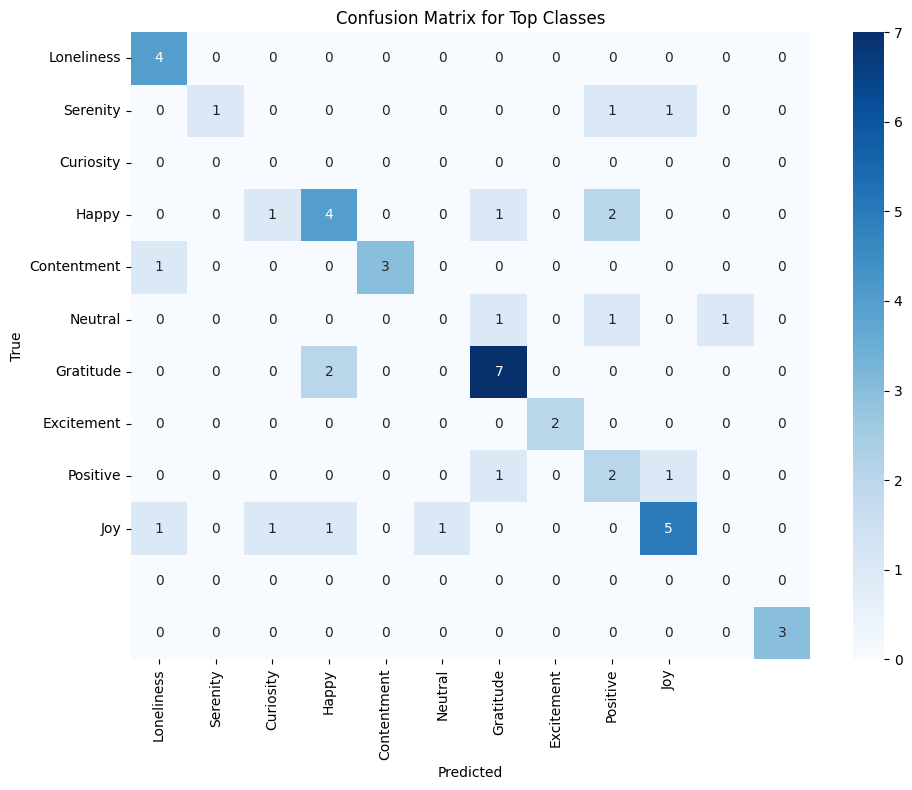

In [394]:
# Training loop with early stopping
num_epochs = 300
best_accuracy = 0.0
patience = 50
no_improvement = 0

try:
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)

        # Learning rate scheduler based on validation loss
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save best model and check for early stopping
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': val_acc,
                'label_encoder': label_encoder
            }, 'best_sentiment_model.pth')
            print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_acc:.4f}')
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement == patience:
                print(f'Early stopping after {patience} epochs without improvement')
                break

except KeyboardInterrupt:
    print("Training interrupted!")

# Load the best model for final evaluation
try:
    # Add this line to register your LabelEncoder class as safe for loading:
    torch.serialization.add_safe_globals([LabelEncoder, np.core.multiarray._reconstruct])
    checkpoint = torch.load('best_sentiment_model.pth', weights_only=False) # Explicitly set weights_only=False
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['accuracy']:.4f}")
except FileNotFoundError:
    print("Best model file not found. Continuing with current model state.")

# Final evaluation on test set
test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print("Classification Report:\n", classification_report(all_labels, all_preds, zero_division=1))

# Convert numeric predictions back to original sentiment labels
predicted_classes = label_encoder.inverse_transform(all_preds)
true_classes = label_encoder.inverse_transform(all_labels)

# Print confusion matrix for top classes (if matplotlib is available)
try:
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Get most frequent classes
    top_class_indices = np.argsort(np.bincount(all_labels))[-10:]  # Top 10 classes
    mask = np.isin(all_labels, top_class_indices)

    if np.sum(mask) > 0:  # If we have any samples from top classes
        cm = confusion_matrix(
            [true_classes[i] for i in range(len(true_classes)) if mask[i]],
            [predicted_classes[i] for i in range(len(predicted_classes)) if mask[i]]
        )

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[label_encoder.inverse_transform([i])[0] for i in top_class_indices],
                   yticklabels=[label_encoder.inverse_transform([i])[0] for i in top_class_indices])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for Top Classes')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        print("Confusion matrix saved to 'confusion_matrix.png'")
except ImportError:
    print("Matplotlib or seaborn not available for confusion matrix visualization")

# Function to predict sentiment for new text
def predict_sentiment(text, model, vectorizer, label_encoder, device):
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Vectorize
    text_tfidf = vectorizer.transform([processed_text]).toarray()

    # Convert to tensor
    text_tensor = torch.FloatTensor(text_tfidf).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(text_tensor)
        _, predicted = torch.max(outputs, 1)

    # Convert to sentiment label
    predicted_sentiment = label_encoder.inverse_transform(predicted.cpu().numpy())[0]

    return predicted_sentiment

# Example of prediction function usage
print("\nExample prediction function:")
print("predict_sentiment('I love this product!', model, vectorizer, label_encoder, device)")